# **Working memory training**: Dynamic connectivity estimation

Karolina Finc | Centre for Modern Interdisciplinary Technologies, Nicolaus Copernicus University in Toruń, Poland

**Last edited:** 09-11-2018


Step 0:  Loading libraries
--------------------------------

In [4]:
%matplotlib inline

import sys
sys.path.append("..")
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from nilearn import datasets, plotting, input_data, signal  # for fetching atlas

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_first_level_design_matrix
from sklearn.covariance import EmpiricalCovariance

import seaborn as sns
sns.reset_orig()

from fctools import denoise, stats

/home/finc/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/finc/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Step 1: Loading data
----------------------------------------------------


In [7]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/01-extracted_timeseries/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/02-correlation_matrices/'

dual_power = np.load(f'{top_dir}dualnback/LB_dualnback_timeseries_power_denoised_acompcor_no_smooth.npy')
dual_schaefer = np.load(f'{top_dir}dualnback/LB_dualnback_timeseries_schaefer_denoised_acompcor_no_smooth.npy')

dual = np.asarray([[dual_power, 'dual_power'], [dual_schaefer, 'dual_schaefer']])

Step 2: Design specification
----------------------------------------------------


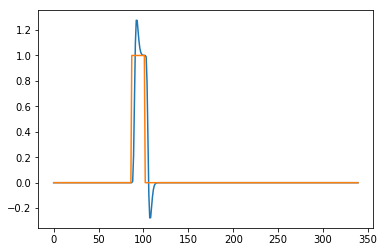

In [8]:
t_r = 2
n_scans = 340

onsets_dir = '../support/onsets_dualnback.csv'
events = pd.read_csv(onsets_dir)
frame_times = np.arange(n_scans) * t_r

events = events[(events.trial_type == '1-back') | (events.trial_type == '2-back')].reset_index()
events['trial_type'] = np.arange(20)

# Step 1
box = make_first_level_design_matrix(frame_times, events, hrf_model = None)
box = box.reset_index()

# Step 2
box_hrf = make_first_level_design_matrix(frame_times, events, hrf_model = 'glover')
box_hrf  = box_hrf.reset_index()
plt.plot(box_hrf.iloc[:,6])
plt.plot(box.iloc[:,6])

Step 3: Weighted correlation - dynamic connectivity
---------------------------

In [9]:
for p in range(1,2): #range(rest.shape[0]):
    data = dual[p,0]

    n_sub = len(data[:, 0, 0, 0])
    n_ses = len(data[0, :, 0, 0])
    cond = np.arange(0,20)
    n_roi = len(data[0, 0, 0, :])
    A = np.zeros((n_roi, n_roi))
    correlation_matrices_dyn_wei = np.zeros((n_sub, n_ses, len(cond), n_roi, n_roi))


    for sub in range(n_sub):
        print(f'Calculating correlations: sub {sub}')
        for ses in range(n_ses):                 
            #correlation_measure = ConnectivityMeasure(cov_estimator=EmpiricalCovariance(store_precision=True, assume_centered=False), kind = 'correlation', discard_diagonal=True)

            for con in range(len(cond)):
                # Zeroing negative values
                rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf[cond[con]]])
                # Concatenating nonzeros blocs
                rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
                # Filtering            
                timeseries_dual = data[sub, ses, rect_box_hrf > 0, :]
                # Calculating weighted correlation coefficient
                for i in range(n_roi):
                    for j in range(i):
                        if i == j:
                            continue
                        else:
                            A[i, j] = stats.corr_wei(timeseries_dual[:, i], timeseries_dual[:, j], rect_nnz)

                fc = A + A.T
                correlation_matrices_dyn_wei[sub, ses, con, :, :] = np.arctanh(fc)

    print(correlation_matrices_dyn_wei.shape)

    np.save(f'{out_dir}dynamic/LB_{dual[p,1]}_dynamic_correlation_matrices.npy', correlation_matrices_dyn_wei)
    sio.savemat(f'{out_dir}dynamic/LB_{dual[p,1]}_dynamic_correlation_matrices.mat', {'correlation_matrices_dyn_wei': correlation_matrices_dyn_wei})
    

Calculating correlations: sub 0


KeyboardInterrupt: 